In [85]:
import re
import random
import pandas as pd
import hashlib

In [86]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.5) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate', 'Jane Eyre, Bronte']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [87]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
DAX,164.480314,18.275590,27.999883,9
Email Auth and Security,247.444151,61.861038,85.176701,4
RAG Project,511.754716,85.292453,134.639751,6
"Jane Eyre, Bronte",523.783788,65.472973,100.682782,8
Azure VM + Developer,769.577227,22.634624,34.412394,34
Azure AD Authentication,948.933976,79.077831,158.769688,12
TSQL,989.817391,41.242391,58.273693,24
Logging in Python,1146.678254,81.905590,126.486677,14
Terraform,1660.716840,92.262047,155.220289,18
Azure Private DNS,1736.675355,91.403966,168.457290,19


# Histogram

sum of ages: ~53422.99


<Axes: >

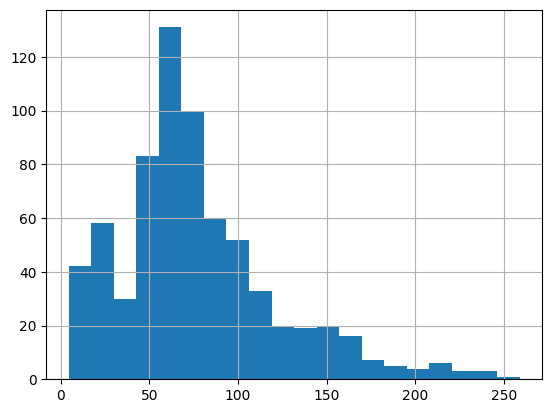

In [88]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~53422.99


<Axes: >

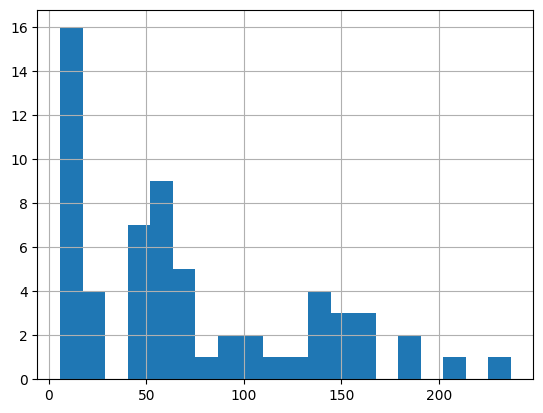

In [89]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Azure Developer Associate']['age'].hist(bins=20)

# Completely Random Shuffle

In [90]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [91]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [92]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [93]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [94]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [95]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [96]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [97]:
n=3
m=existing_cards.shape[0]//100
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 693
Total card age: 53422.99


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
18,Azure Developer Associate,This item tests the candidate’s knowledge of i...,2458b75c2c634b652370c5c07508716d,-236.823024,72.823937,236.823024,-4515.084076,0.863056,0,0
19,Azure Developer Associate,You have an Azure Service Bus instance.\nYou n...,459dcfc4b1d94afba066822672cf1d70,-183.016297,72.823937,236.823024,-4515.084076,0.863056,3,0
20,Azure Developer Associate,This item tests the candidate's knowledge of A...,fc4d22872d5cea1260c16e1f9b04b560,-160.625052,72.823937,236.823024,-4515.084076,0.863056,6,0
21,Azure Developer Associate,Azure Monitor Resource Health alerts are used ...,059f4beba5b43f0dfaf51e36df00e01b,-146.127896,72.823937,236.823024,-4515.084076,0.863056,9,0
261,Azure Developer Associate,"In Azure Application Insights, Preaggregated s...",057ceeb01268094ef085807f1b4e48eb,-139.556400,72.823937,236.823024,-4515.084076,0.863056,12,0
23,Azure Developer Associate,This item tests the candidate’s knowledge of c...,590e2741b4bdebe9d16ab3e32006139c,-110.680186,72.823937,236.823024,-4515.084076,0.863056,15,0
24,Azure Developer Associate,You are a developing a serverless API using Az...,e0ca187d857e4165727517c2e4b81dd6,-96.849821,72.823937,236.823024,-4515.084076,0.863056,18,0
264,Azure Developer Associate,You need to deploy an Azure Files share along ...,932245130addc67369d5402942504c81,-74.048414,72.823937,236.823024,-4515.084076,0.863056,21,0
26,Azure Developer Associate,You are developing an Azure Functions app that...,5e83b9749bf8b06e631df653a83ba32a,-67.412844,72.823937,236.823024,-4515.084076,0.863056,24,0
27,Azure Developer Associate,The delete rule action supports both block blo...,d08c888b697fbcdd868eafe894ecc100,-62.454843,72.823937,236.823024,-4515.084076,0.863056,27,0


## Age Mean

In [98]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [99]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [100]:
# n=5
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [101]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [102]:
existing_cards.sort_values('age', ascending=False).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
175,C# Basics,.NET uses a garbage collector that automatical...,43bedaac447bb0b9a8a6f14b650981e4,-4.549516,74.881392,127.263168,-2321.323157,0.829903,30,0
508,Azure Developer Associate,For the .NET SDK for Azure Cosmos DB for NoSQL...,e2ff6f3c584a2c6c5faf78dcae2eb263,-5.800719,72.823937,236.823024,-4515.084076,0.863056,61,1
277,Azure Developer Associate,Configuration data stored in an App Configurat...,22293608d8680b7f657f335dbf029202,-7.189906,72.823937,236.823024,-4515.084076,0.863056,60,0
38,Azure Developer Associate,App Configuration doesn't version key values a...,c5b1da2f26c3dc2ad56cbaba6c51b9ed,-8.197206,72.823937,236.823024,-4515.084076,0.863056,59,2
37,Azure Developer Associate,"In Azure App Configuration,\nFeature manager: ...",c901a14baf95edb2e2619bb15f279978,-9.048290,72.823937,236.823024,-4515.084076,0.863056,58,1
276,Azure Developer Associate,The .NET SDK for Azure Cosmos DB for NoSQL shi...,f5da4a10007b58ba8af2aaafb7b97a48,-9.243739,72.823937,236.823024,-4515.084076,0.863056,57,0
36,Azure Developer Associate,"In Azure App Configuration,\nFeature flag: A f...",8bcb1de29c054bd4964e31961734bbbd,-9.517143,72.823937,236.823024,-4515.084076,0.863056,56,2
507,Azure Developer Associate,Azure App Configuration encrypts sensitive inf...,fc0360a578522e808e4d680619664a40,-9.839663,72.823937,236.823024,-4515.084076,0.863056,55,1
275,Azure Developer Associate,The .NET SDK for Azure Cosmos DB for NoSQL shi...,6b266a08728213cd70fbb1cf8e56b84d,-10.173397,72.823937,236.823024,-4515.084076,0.863056,54,0
333,JavaScript Concepts,Front: What are tagged templates and how do yo...,c01058319c7e76b3d1c1a0e23a0ab7af,-10.586058,53.509368,172.302103,-4013.202620,0.753863,74,2


In [103]:
existing_cards.head(10).sum()

head                   Azure Developer AssociateAzure Developer Assoc...
body                   This item tests the candidate’s knowledge of i...
hash                   2458b75c2c634b652370c5c07508716d459dcfc4b1d94a...
age                                                         -1277.594776
subject_mean_age                                              728.239367
subject_highest_age                                           2368.23024
subject_age_sum                                            -45150.840761
head_random_roll                                                8.630556
count                                                                135
n_fold                                                                 0
dtype: object

In [104]:
existing_cards['age'].mean()

-77.08944952705134